In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (for correlation p-values)
try:
    from scipy.stats import pearsonr, spearmanr
except Exception:
    pearsonr, spearmanr = None, None

# -----------------------------
# Global plotting style (Nature-ish, minimal, readable)
# -----------------------------
plt.rcParams["figure.dpi"] = 160
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 9
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["axes.labelsize"] = 9
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.25
plt.rcParams["legend.frameon"] = False

FIG_DIR = os.path.join("..", "results", "figs")
os.makedirs(FIG_DIR, exist_ok=True)

def _first_existing_path(paths):
    for p in paths:
        if p is None:
            continue
        if os.path.exists(p):
            return p
    return None

def load_exp14_summary():
    # Try common locations (repo-style + local upload-style).
    candidates = [
        os.path.join("..", "results", "tables", "exp14_multicity_tabular_summary.csv"),
        os.path.join("..", "results", "tables", "exp14_multicity_tabular_summary_v2.csv"),
        os.path.join("..", "results", "tables", "exp14_multicity_tabular_summary_v3.csv"),
        os.path.join("results", "tables", "exp14_multicity_tabular_summary.csv"),
        os.path.join("results", "tables", "exp14_multicity_tabular_summary_v2.csv"),
        os.path.join("results", "tables", "exp14_multicity_tabular_summary_v3.csv"),
        os.path.join(".", "exp14_multicity_tabular_summary.csv"),
        os.path.join(".", "exp14_multicity_tabular_summary_v2.csv"),
        "/mnt/data/exp14_multicity_tabular_summary.csv",
    ]
    path = _first_existing_path(candidates)
    if path is None:
        raise FileNotFoundError(
            "Could not find exp14 summary CSV. "
            "Please place it under ../results/tables/exp14_multicity_tabular_summary.csv "
            "or set CSV_PATH manually."
        )

    print(f"[OK] Loading Exp14 summary from: {path}")
    df = pd.read_csv(path)
    return df

df = load_exp14_summary()
print("Rows:", len(df), "| Cols:", len(df.columns))
df.head(3)


[OK] Loading Exp14 summary from: ../results/tables/exp14_multicity_tabular_summary.csv
Rows: 31 | Cols: 37


,City,HorizonSteps,MeanFlow_Test,Local_MAE_Ratio,Persist_MAE,Skill_vs_Persist,Local_Train_MAE,Global_Train_MAE,Local_MAE,Global_MAE,...,TopKMass3,NumNonZeroWeights,NumTrain,NumVal,NumTest,NumFitSamples,NumEvalSamples,NumPeers,CacheHash,ModelType
0,augsburg,12,159.481020,0.220866,46.377680,0.240499,35.808021,47.675901,35.223910,44.856960,...,0.370551,29,300000,200000,200000,4000,4000,31,6397cce5fc75,histgb
1,basel,12,134.480387,0.523288,77.346011,0.090167,39.876265,55.851809,70.371956,67.470687,...,0.821584,20,91707,30107,30184,4000,4000,31,6397cce5fc75,histgb
2,bern,12,145.537556,0.884960,76.598774,-0.681422,78.182725,82.349724,128.794894,71.549527,...,0.812993,17,300000,196935,197000,4000,4000,31,6397cce5fc75,histgb


In [3]:

# -----------------------------
# Basic cleaning and sanity checks
# -----------------------------
required_cols = [
    "City", "PIER",
    "Local_MAE", "Global_MAE", "Router_MAE",
    "Delta_Global", "Delta_Router",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Coerce key numeric columns
numeric_cols = [
    "PIER", "Local_MAE", "Global_MAE", "Router_MAE",
    "Delta_Global", "Delta_Router",
    "PairwiseMeanAbsDiff", "ClosestPeerMeanAbsDiff",
    "WeightEntropy", "WeightEntropyNorm", "EffectivePeers_HHI",
    "FitDistance",
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["City"] = df["City"].astype(str)

# Drop rows with missing essential values
before = len(df)
df = df.dropna(subset=["City", "PIER", "Delta_Global", "Delta_Router"]).copy()
after = len(df)
print(f"Dropped {before-after} rows with missing essentials. Remaining: {after}")

# Quick look at potential extreme values
print("Top-5 by PIER:")
display(df.sort_values("PIER", ascending=False)[["City", "PIER", "Delta_Global", "Delta_Router", "Local_MAE", "Router_MAE", "Global_MAE"]].head(5))

print("\nBottom-5 by PIER:")
display(df.sort_values("PIER", ascending=True)[["City", "PIER", "Delta_Global", "Delta_Router", "Local_MAE", "Router_MAE", "Global_MAE"]].head(5))


Dropped 0 rows with missing essentials. Remaining: 31
Top-5 by PIER:


,City,PIER,Delta_Global,Delta_Router,Local_MAE,Router_MAE,Global_MAE
19,paris,364.643192,204.959317,217.550574,197.009310,414.559884,401.968627
21,santander,152.419282,-51.311443,4.298078,178.007357,182.305435,126.695914
14,losangeles,96.628977,60.176765,37.964700,121.005801,158.970502,181.182567
2,bern,83.545522,-57.245367,-33.041302,128.794894,95.753592,71.549527
15,luzern,71.128942,-35.828337,-31.073160,153.722327,122.649168,117.893991



Bottom-5 by PIER:


,City,PIER,Delta_Global,Delta_Router,Local_MAE,Router_MAE,Global_MAE
5,bremen,9.177211,4.042782,0.714794,54.233149,54.947943,58.275930
11,hamburg,9.494974,5.396672,0.577776,49.206639,49.784415,54.603311
22,speyer,9.748049,4.392539,1.761928,43.624621,45.386549,48.017160
7,constance,12.219220,2.328868,-0.133247,37.433328,37.300082,39.762197
10,graz,12.650447,7.696741,1.948825,44.782232,46.731057,52.478973


In [4]:

# -----------------------------
# Outlier detection helpers (robust + transparent)
# -----------------------------
def mad_based_zscore(x: np.ndarray, eps: float = 1e-12):
    x = np.asarray(x, dtype=float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad < eps:
        return np.zeros_like(x)
    return 0.6745 * (x - med) / mad

def iqr_bounds(x: np.ndarray, k: float = 1.5):
    x = np.asarray(x, dtype=float)
    q1 = np.nanpercentile(x, 25)
    q3 = np.nanpercentile(x, 75)
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return lo, hi, q1, q3, iqr

def flag_outliers(df_in: pd.DataFrame, col: str, method: str = "iqr", **kwargs):
    df_in = df_in.copy()
    x = df_in[col].to_numpy(dtype=float)
    if method == "iqr":
        lo, hi, q1, q3, iqr = iqr_bounds(x, k=float(kwargs.get("k", 1.5)))
        df_in["_is_outlier"] = (x < lo) | (x > hi)
        meta = dict(method="iqr", lo=lo, hi=hi, q1=q1, q3=q3, iqr=iqr)
        return df_in, meta
    elif method == "mad":
        z = mad_based_zscore(x)
        thr = float(kwargs.get("thr", 3.5))
        df_in["_is_outlier"] = np.abs(z) > thr
        meta = dict(method="mad", thr=thr)
        return df_in, meta
    else:
        raise ValueError("method must be 'iqr' or 'mad'")

# Flag outliers by PIER (two common robust choices)
df_iqr, meta_iqr = flag_outliers(df, col="PIER", method="iqr", k=1.5)
df_mad, meta_mad = flag_outliers(df, col="PIER", method="mad", thr=3.5)

outliers_iqr = df_iqr[df_iqr["_is_outlier"]].sort_values("PIER", ascending=False)
outliers_mad = df_mad[df_mad["_is_outlier"]].sort_values("PIER", ascending=False)

print("IQR outlier rule on PIER:", meta_iqr)
print("MAD outlier rule on PIER:", meta_mad)

print("\nOutliers by IQR (PIER):")
display(outliers_iqr[["City", "PIER", "Delta_Global", "Delta_Router"]])

print("\nOutliers by MAD (PIER):")
display(outliers_mad[["City", "PIER", "Delta_Global", "Delta_Router"]])

# Manual list (common in rebuttals: show 'with' and 'without' a known outlier)
MANUAL_EXCLUDE = ["paris"]
print("\nManual exclude list:", MANUAL_EXCLUDE)


IQR outlier rule on PIER: {'method': 'iqr', 'lo': np.float64(-30.966714839502814), 'hi': np.float64(96.60691326589294), 'q1': np.float64(16.873395700020595), 'q3': np.float64(48.766802726369534), 'iqr': np.float64(31.89340702634894)}
MAD outlier rule on PIER: {'method': 'mad', 'thr': 3.5}

Outliers by IQR (PIER):


,City,PIER,Delta_Global,Delta_Router
19,paris,364.643192,204.959317,217.550574
21,santander,152.419282,-51.311443,4.298078
14,losangeles,96.628977,60.176765,37.964700



Outliers by MAD (PIER):


,City,PIER,Delta_Global,Delta_Router
19,paris,364.643192,204.959317,217.550574
21,santander,152.419282,-51.311443,4.298078



Manual exclude list: ['paris']


In [5]:

# -----------------------------
# Correlation helpers
# -----------------------------
def corr_pair(x: np.ndarray, y: np.ndarray):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    if x.size < 3:
        return dict(n=int(x.size), pearson=np.nan, pearson_p=np.nan, spearman=np.nan, spearman_p=np.nan)

    if pearsonr is not None:
        pr, pp = pearsonr(x, y)
    else:
        pr = np.corrcoef(x, y)[0, 1]
        pp = np.nan

    if spearmanr is not None:
        sr, sp = spearmanr(x, y)
    else:
        # Fall back to Pearson correlation of ranks
        xr = pd.Series(x).rank().to_numpy()
        yr = pd.Series(y).rank().to_numpy()
        sr = np.corrcoef(xr, yr)[0, 1]
        sp = np.nan

    return dict(n=int(x.size), pearson=float(pr), pearson_p=float(pp), spearman=float(sr), spearman_p=float(sp))

def print_corr(df_in: pd.DataFrame, xcol: str, ycol: str, label: str):
    stats = corr_pair(df_in[xcol].to_numpy(), df_in[ycol].to_numpy())
    print(f"[{label}] n={stats['n']} | Pearson r={stats['pearson']:.3f} (p={stats['pearson_p']:.2e}) | "
          f"Spearman ρ={stats['spearman']:.3f} (p={stats['spearman_p']:.2e})")

def add_health_flags(df_in: pd.DataFrame) -> pd.DataFrame:
    df2 = df_in.copy()
    df2["Healthy"] = (df2["Delta_Global"] >= 0.0) & (df2["Delta_Router"] >= 0.0)
    df2["Unhealthy"] = ~df2["Healthy"]
    return df2

df0 = add_health_flags(df)

# Correlations on the full set
print_corr(df0, "PIER", "Delta_Router", "All: PIER vs ΔRouter")
print_corr(df0, "PIER", "Delta_Global", "All: PIER vs ΔGlobal")

# Exclude manual outliers
df_no_manual = df0[~df0["City"].isin(MANUAL_EXCLUDE)].copy()
print_corr(df_no_manual, "PIER", "Delta_Router", "No-manual-outliers: PIER vs ΔRouter")
print_corr(df_no_manual, "PIER", "Delta_Global", "No-manual-outliers: PIER vs ΔGlobal")

# Exclude IQR outliers
df_no_iqr = add_health_flags(df_iqr[~df_iqr["_is_outlier"]].drop(columns=["_is_outlier"]))
print_corr(df_no_iqr, "PIER", "Delta_Router", "No-IQR-outliers: PIER vs ΔRouter")
print_corr(df_no_iqr, "PIER", "Delta_Global", "No-IQR-outliers: PIER vs ΔGlobal")

# Also look at the healthy subset only (arguably the cleanest 'replacement-cost' regime)
print_corr(df_no_iqr[df_no_iqr["Healthy"]], "PIER", "Delta_Router", "Healthy & No-IQR-outliers: PIER vs ΔRouter")
print_corr(df_no_iqr[df_no_iqr["Healthy"]], "PIER", "Delta_Global", "Healthy & No-IQR-outliers: PIER vs ΔGlobal")


[All: PIER vs ΔRouter] n=31 | Pearson r=0.837 (p=4.58e-09) | Spearman ρ=0.329 (p=7.03e-02)
[All: PIER vs ΔGlobal] n=31 | Pearson r=0.642 (p=9.89e-05) | Spearman ρ=0.227 (p=2.19e-01)
[No-manual-outliers: PIER vs ΔRouter] n=30 | Pearson r=-0.008 (p=9.67e-01) | Spearman ρ=0.260 (p=1.65e-01)
[No-manual-outliers: PIER vs ΔGlobal] n=30 | Pearson r=-0.336 (p=6.96e-02) | Spearman ρ=0.147 (p=4.37e-01)
[No-IQR-outliers: PIER vs ΔRouter] n=28 | Pearson r=-0.363 (p=5.77e-02) | Spearman ρ=0.205 (p=2.95e-01)
[No-IQR-outliers: PIER vs ΔGlobal] n=28 | Pearson r=-0.329 (p=8.74e-02) | Spearman ρ=0.188 (p=3.37e-01)
[Healthy & No-IQR-outliers: PIER vs ΔRouter] n=20 | Pearson r=0.756 (p=1.14e-04) | Spearman ρ=0.758 (p=1.08e-04)
[Healthy & No-IQR-outliers: PIER vs ΔGlobal] n=20 | Pearson r=0.577 (p=7.78e-03) | Spearman ρ=0.698 (p=6.25e-04)


[Saved] ../results/figs/exp14_pier_distribution_all.png


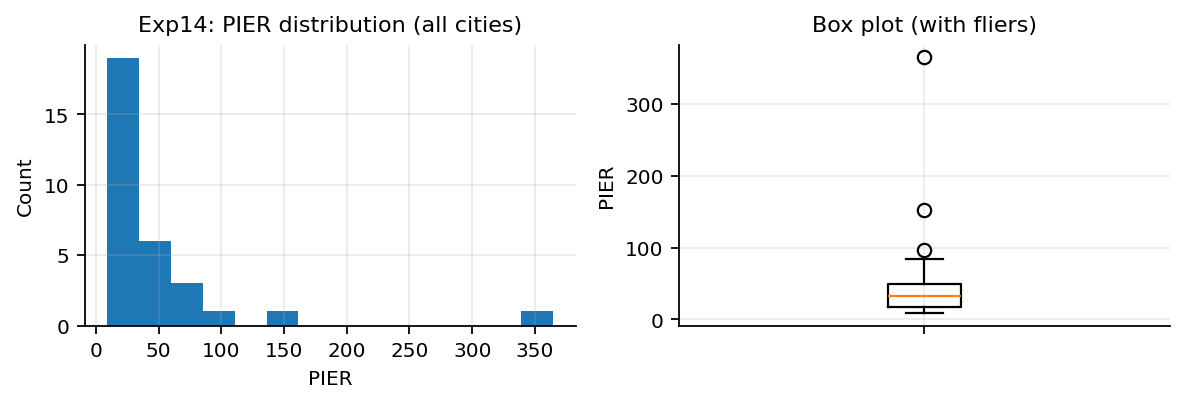

[Saved] ../results/figs/exp14_pier_distribution_no_iqr.png


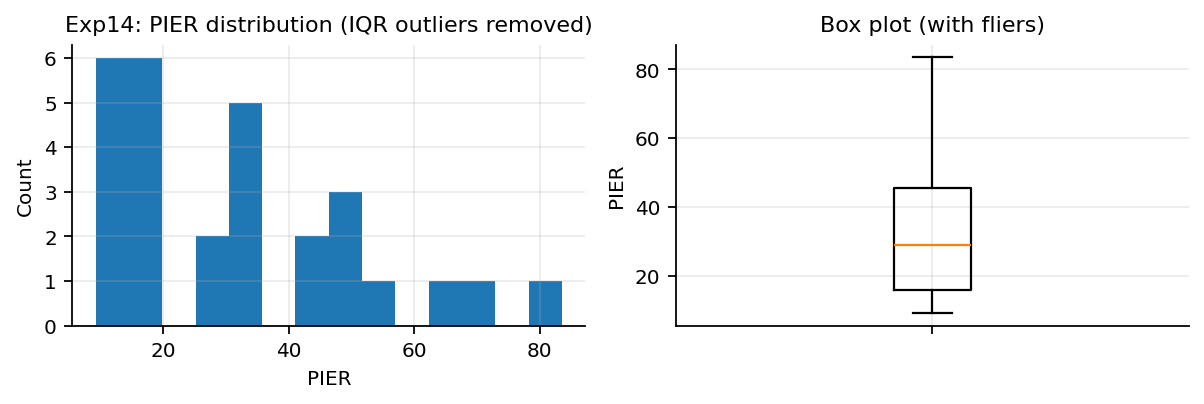

In [6]:

# -----------------------------
# Plot 1: PIER distribution + highlight outliers
# -----------------------------
def plot_pier_distribution(df_in: pd.DataFrame, title: str, save_name: str = None):
    x = df_in["PIER"].to_numpy(dtype=float)
    x = x[np.isfinite(x)]

    fig = plt.figure(figsize=(7.6, 2.6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.hist(x, bins=14)
    ax1.set_title(title)
    ax1.set_xlabel("PIER")
    ax1.set_ylabel("Count")

    ax2 = plt.subplot(1, 2, 2)
    ax2.boxplot(x, vert=True, showfliers=True)
    ax2.set_title("Box plot (with fliers)")
    ax2.set_ylabel("PIER")
    ax2.set_xticks([1])
    ax2.set_xticklabels([""])

    plt.tight_layout()

    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)

    plt.show()

plot_pier_distribution(df0, "Exp14: PIER distribution (all cities)", save_name="exp14_pier_distribution_all.png")
plot_pier_distribution(df_no_iqr, "Exp14: PIER distribution (IQR outliers removed)", save_name="exp14_pier_distribution_no_iqr.png")


[Saved] ../results/figs/exp14_scatter_pier_vs_delta_router.png


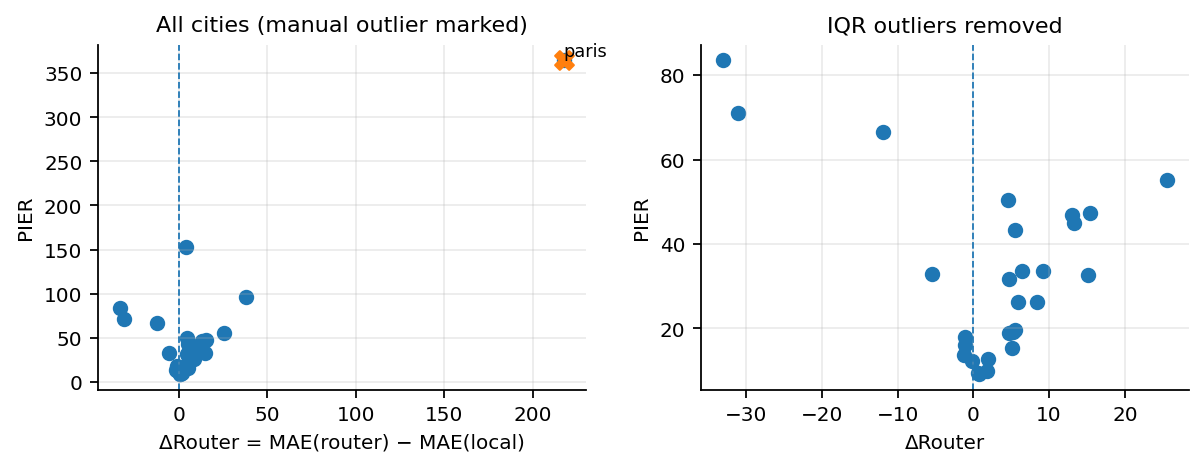

In [7]:

# -----------------------------
# Plot 2: Scatter PIER vs ΔRouter (with outliers marked)
# -----------------------------
def scatter_pier_vs_delta(df_all: pd.DataFrame, df_clean: pd.DataFrame, label_clean: str, save_name: str = None):
    fig = plt.figure(figsize=(7.6, 3.0))

    ax1 = plt.subplot(1, 2, 1)
    ax1.scatter(df_all["Delta_Router"], df_all["PIER"], s=35)
    for _, r in df_all[df_all["City"].isin(MANUAL_EXCLUDE)].iterrows():
        ax1.scatter([r["Delta_Router"]], [r["PIER"]], s=70, marker="X")
        ax1.text(r["Delta_Router"], r["PIER"], str(r["City"]), fontsize=8, ha="left", va="bottom")
    ax1.axvline(0.0, linewidth=0.8, linestyle="--")
    ax1.set_xlabel("ΔRouter = MAE(router) − MAE(local)")
    ax1.set_ylabel("PIER")
    ax1.set_title("All cities (manual outlier marked)")

    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(df_clean["Delta_Router"], df_clean["PIER"], s=35)
    ax2.axvline(0.0, linewidth=0.8, linestyle="--")
    ax2.set_xlabel("ΔRouter")
    ax2.set_ylabel("PIER")
    ax2.set_title(label_clean)

    plt.tight_layout()
    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)
    plt.show()

scatter_pier_vs_delta(df0, df_no_iqr, "IQR outliers removed", save_name="exp14_scatter_pier_vs_delta_router.png")


[Saved] ../results/figs/exp14_quadrant_all.png


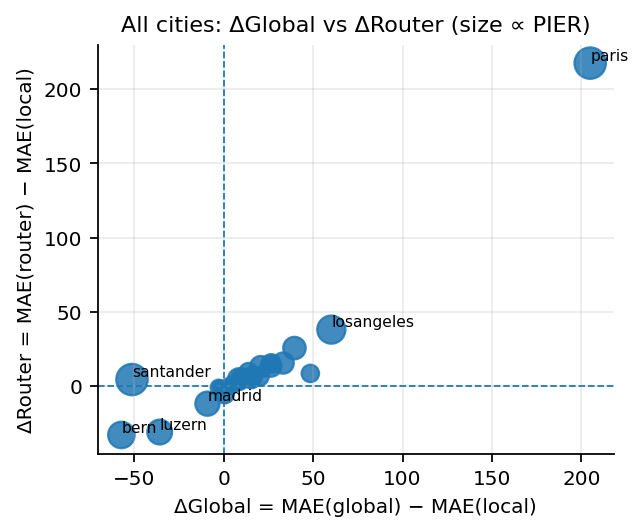

[Saved] ../results/figs/exp14_quadrant_no_iqr.png


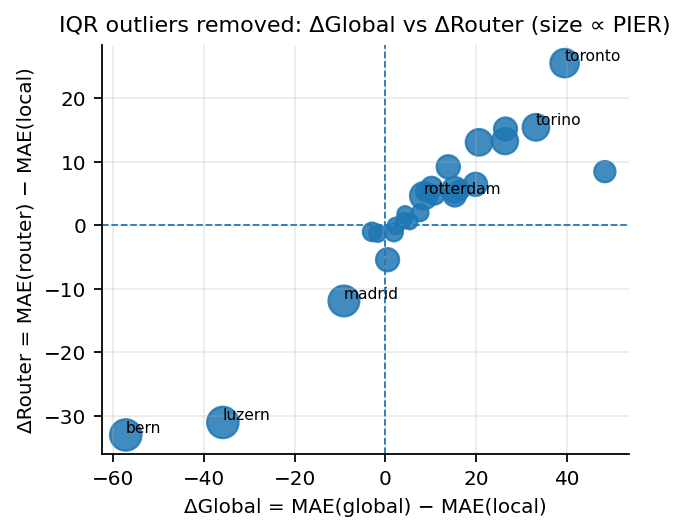

In [8]:

# -----------------------------
# Plot 3: Quadrant plot (ΔGlobal vs ΔRouter) with point size ~ PIER
# -----------------------------
def quadrant_plot(df_in: pd.DataFrame, title: str, save_name: str = None):
    dfp = df_in.copy()
    # Size scaling (robust): clip at 95th percentile to avoid one point dominating
    s_raw = dfp["PIER"].to_numpy(dtype=float)
    s_clip = np.nanpercentile(s_raw, 95)
    s = np.clip(s_raw, 0.0, s_clip)
    s = 25.0 + 175.0 * (s / (s_clip + 1e-12))

    fig = plt.figure(figsize=(4.1, 3.4))
    ax = plt.gca()
    ax.scatter(dfp["Delta_Global"], dfp["Delta_Router"], s=s, alpha=0.85)

    ax.axhline(0.0, linewidth=0.8, linestyle="--")
    ax.axvline(0.0, linewidth=0.8, linestyle="--")

    ax.set_xlabel("ΔGlobal = MAE(global) − MAE(local)")
    ax.set_ylabel("ΔRouter = MAE(router) − MAE(local)")
    ax.set_title(title)

    # Annotate a few extremes (largest PIER after filtering)
    top = dfp.sort_values("PIER", ascending=False).head(6)
    for _, r in top.iterrows():
        ax.text(r["Delta_Global"], r["Delta_Router"], str(r["City"]), fontsize=7, ha="left", va="bottom")

    plt.tight_layout()
    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)
    plt.show()

quadrant_plot(df0, "All cities: ΔGlobal vs ΔRouter (size ∝ PIER)", save_name="exp14_quadrant_all.png")
quadrant_plot(df_no_iqr, "IQR outliers removed: ΔGlobal vs ΔRouter (size ∝ PIER)", save_name="exp14_quadrant_no_iqr.png")


[Saved] ../results/figs/exp14_pier_vs_fitdistance.png


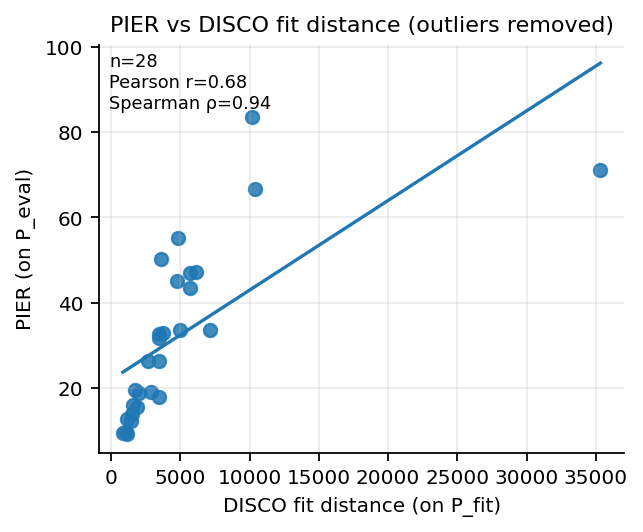

[Saved] ../results/figs/exp14_pier_vs_pairwise_mean_abs_diff.png


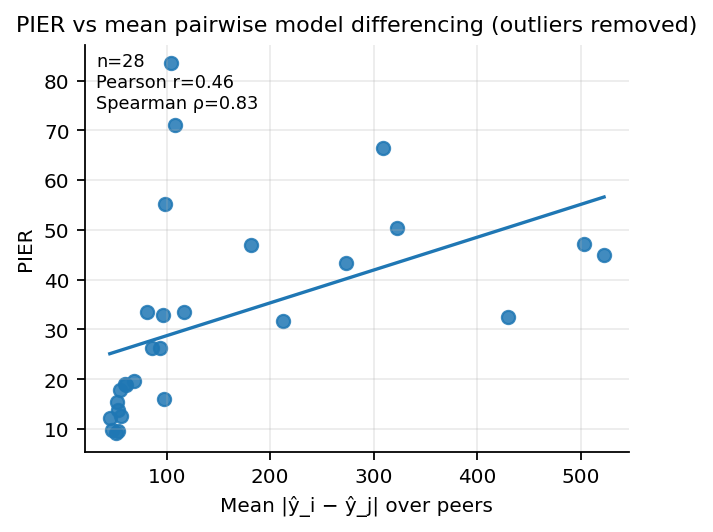

[Saved] ../results/figs/exp14_pier_vs_entropy_norm.png


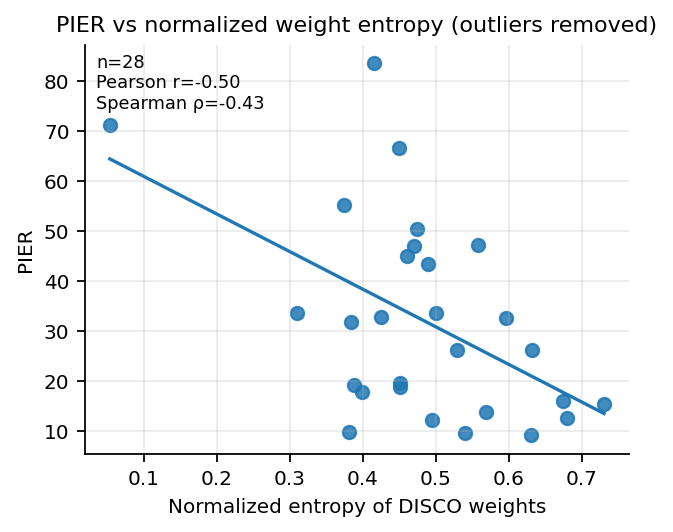

[Saved] ../results/figs/exp14_pier_vs_effective_peers.png


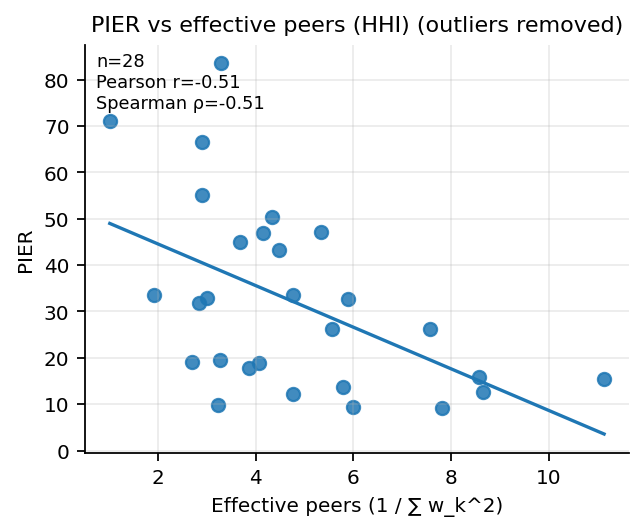

In [9]:

# -----------------------------
# Evidence chain checks (after outlier removal):
# 1) PIER aligns with internal "approximation hardness" (FitDistance, PairwiseMeanAbsDiff)
# 2) PIER relates to how concentrated the convex fit is (entropy / effective peers)
# -----------------------------
def scatter_with_fit(df_in: pd.DataFrame, xcol: str, ycol: str, title: str, xlabel: str, ylabel: str, save_name: str = None):
    x = df_in[xcol].to_numpy(dtype=float)
    y = df_in[ycol].to_numpy(dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    fig = plt.figure(figsize=(4.1, 3.4))
    ax = plt.gca()
    ax.scatter(x, y, s=35, alpha=0.85)

    # Linear fit (least squares) for visualization only
    if x.size >= 3:
        a, b = np.polyfit(x, y, deg=1)
        xx = np.linspace(np.min(x), np.max(x), 100)
        yy = a * xx + b
        ax.plot(xx, yy, linewidth=1.5)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Correlation report (robust: Pearson + Spearman)
    stats = corr_pair(x, y)
    ax.text(
        0.02, 0.98,
        f"n={stats['n']}\nPearson r={stats['pearson']:.2f}\nSpearman ρ={stats['spearman']:.2f}",
        transform=ax.transAxes,
        ha="left", va="top", fontsize=8
    )

    plt.tight_layout()
    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)
    plt.show()

df_clean = df_no_iqr.copy()

if "FitDistance" in df_clean.columns:
    scatter_with_fit(
        df_clean, "FitDistance", "PIER",
        title="PIER vs DISCO fit distance (outliers removed)",
        xlabel="DISCO fit distance (on P_fit)",
        ylabel="PIER (on P_eval)",
        save_name="exp14_pier_vs_fitdistance.png",
    )

if "PairwiseMeanAbsDiff" in df_clean.columns:
    scatter_with_fit(
        df_clean, "PairwiseMeanAbsDiff", "PIER",
        title="PIER vs mean pairwise model differencing (outliers removed)",
        xlabel="Mean |ŷ_i − ŷ_j| over peers",
        ylabel="PIER",
        save_name="exp14_pier_vs_pairwise_mean_abs_diff.png",
    )

if "WeightEntropyNorm" in df_clean.columns:
    scatter_with_fit(
        df_clean, "WeightEntropyNorm", "PIER",
        title="PIER vs normalized weight entropy (outliers removed)",
        xlabel="Normalized entropy of DISCO weights",
        ylabel="PIER",
        save_name="exp14_pier_vs_entropy_norm.png",
    )

if "EffectivePeers_HHI" in df_clean.columns:
    scatter_with_fit(
        df_clean, "EffectivePeers_HHI", "PIER",
        title="PIER vs effective peers (HHI) (outliers removed)",
        xlabel="Effective peers (1 / ∑ w_k^2)",
        ylabel="PIER",
        save_name="exp14_pier_vs_effective_peers.png",
    )


In [10]:

# -----------------------------
# Summary tables for writing the paper (after outlier removal)
# -----------------------------
df_clean = df_no_iqr.copy()

# Define a few interpretable "types" (paper-friendly):
# - Healthy unique:     ΔGlobal>0 and ΔRouter>0 and high PIER
# - Healthy redundant:  ΔGlobal>0 and ΔRouter>0 and low PIER
# - Unhealthy unique:   (ΔGlobal<0 or ΔRouter<0) and high PIER
# - Unhealthy redundant:(ΔGlobal<0 or ΔRouter<0) and low PIER
#
# Thresholds are robust quantiles (not arbitrary constants).
pier_hi = float(df_clean["PIER"].quantile(0.75))
pier_lo = float(df_clean["PIER"].quantile(0.25))

df_clean["Type"] = "Other"
df_clean.loc[df_clean["Healthy"] & (df_clean["PIER"] >= pier_hi), "Type"] = "Healthy-Unique"
df_clean.loc[df_clean["Healthy"] & (df_clean["PIER"] <= pier_lo), "Type"] = "Healthy-Redundant"
df_clean.loc[df_clean["Unhealthy"] & (df_clean["PIER"] >= pier_hi), "Type"] = "Unhealthy-Unique"
df_clean.loc[df_clean["Unhealthy"] & (df_clean["PIER"] <= pier_lo), "Type"] = "Unhealthy-Redundant"

print("PIER quantiles (clean): Q25=%.3f, Q75=%.3f" % (pier_lo, pier_hi))
print("\nCounts by Type:")
display(df_clean["Type"].value_counts().to_frame("count"))

cols_show = [
    "City", "Type", "PIER",
    "Local_MAE", "Global_MAE", "Router_MAE",
    "Delta_Global", "Delta_Router",
    "Local_MAE_Ratio", "Skill_vs_Persist",
    "ClosestPeerName", "ClosestPeerMeanAbsDiff",
    "WeightEntropyNorm", "EffectivePeers_HHI",
]

cols_show = [c for c in cols_show if c in df_clean.columns]

print("\nTop-10 PIER cities (clean):")
display(df_clean.sort_values("PIER", ascending=False)[cols_show].head(10))

print("\nBottom-10 PIER cities (clean):")
display(df_clean.sort_values("PIER", ascending=True)[cols_show].head(10))

print("\nHealthy-Unique examples:")
display(df_clean[df_clean["Type"] == "Healthy-Unique"].sort_values("PIER", ascending=False)[cols_show].head(8))

print("\nUnhealthy-Unique examples:")
display(df_clean[df_clean["Type"] == "Unhealthy-Unique"].sort_values("PIER", ascending=False)[cols_show].head(8))


PIER quantiles (clean): Q25=15.813, Q75=45.524

Counts by Type:


,count
Type,
Other,14
Healthy-Redundant,5
Healthy-Unique,4
Unhealthy-Unique,3
Unhealthy-Redundant,2



Top-10 PIER cities (clean):


,City,Type,PIER,Local_MAE,Global_MAE,Router_MAE,Delta_Global,Delta_Router,Local_MAE_Ratio,Skill_vs_Persist,ClosestPeerName,ClosestPeerMeanAbsDiff,WeightEntropyNorm,EffectivePeers_HHI
2,bern,Unhealthy-Unique,83.545522,128.794894,71.549527,95.753592,-57.245367,-33.041302,0.884960,-0.681422,taipeh,82.967312,0.415098,3.297453
15,luzern,Unhealthy-Unique,71.128942,153.722327,117.893991,122.649168,-35.828337,-31.073160,0.525481,0.030337,taipeh,71.169494,0.053259,1.015054
16,madrid,Unhealthy-Unique,66.524021,140.528258,131.404142,128.586161,-9.124116,-11.942097,0.283951,0.017000,taipeh,77.375544,0.450206,2.897093
27,toronto,Healthy-Unique,55.195717,79.269703,118.824540,104.787328,39.554837,25.517625,0.296637,0.406293,essen,58.900333,0.374157,2.898788
20,rotterdam,Healthy-Unique,50.319309,69.751832,78.226684,74.371087,8.474853,4.619255,0.284237,0.223022,darmstadt,50.637449,0.474342,4.341472
26,torino,Healthy-Unique,47.214296,80.722430,113.952181,96.131756,33.229751,15.409326,0.204417,0.350332,manchester,64.598982,0.558327,5.330719
18,marseille,Healthy-Unique,46.921215,97.937675,118.622064,110.982054,20.684388,13.044378,0.244052,0.216523,strasbourg,47.196646,0.470796,4.148934
17,manchester,Other,45.057750,76.714563,103.129340,89.941381,26.414777,13.226818,0.185641,0.291325,bolton,55.416824,0.460097,3.677281
25,taipeh,Other,43.308824,140.143762,155.460282,145.701779,15.316520,5.558017,0.259895,0.168725,strasbourg,58.818738,0.489882,4.475443
12,kassel,Other,33.592348,90.243461,104.139108,99.428316,13.895647,9.184855,0.317508,0.245483,augsburg,30.409825,0.500650,4.768903



Bottom-10 PIER cities (clean):


,City,Type,PIER,Local_MAE,Global_MAE,Router_MAE,Delta_Global,Delta_Router,Local_MAE_Ratio,Skill_vs_Persist,ClosestPeerName,ClosestPeerMeanAbsDiff,WeightEntropyNorm,EffectivePeers_HHI
5,bremen,Healthy-Redundant,9.177211,54.233149,58.275930,54.947943,4.042782,0.714794,0.296685,0.201207,hamburg,11.794414,0.631032,7.812277
11,hamburg,Healthy-Redundant,9.494974,49.206639,54.603311,49.784415,5.396672,0.577776,0.335525,0.191602,bremen,12.684031,0.539914,5.994265
22,speyer,Healthy-Redundant,9.748049,43.624621,48.017160,45.386549,4.392539,1.761928,0.310350,0.225048,bremen,10.243108,0.381840,3.235769
7,constance,Unhealthy-Redundant,12.219220,37.433328,39.762197,37.300082,2.328868,-0.133247,0.330728,0.144582,stuttgart,13.281001,0.495260,4.768016
10,graz,Healthy-Redundant,12.650447,44.782232,52.478973,46.731057,7.696741,1.948825,0.209234,0.305447,augsburg,14.680387,0.679685,8.655642
30,zurich,Unhealthy-Redundant,13.765034,60.490899,58.810504,59.209903,-1.680395,-1.280996,0.306806,0.109237,bremen,19.614172,0.568660,5.778656
0,augsburg,Healthy-Redundant,15.421061,35.223910,44.856960,40.295411,9.633050,5.071501,0.220866,0.240499,london,16.260651,0.730832,11.130546
23,strasbourg,Other,15.944262,82.737752,84.636697,81.600701,1.898945,-1.137051,0.308443,0.163486,bremen,25.420287,0.673936,8.576017
1,basel,Other,17.802529,70.371956,67.470687,69.313563,-2.901269,-1.058392,0.523288,0.090167,constance,20.774552,0.398853,3.868313
8,darmstadt,Other,18.814754,40.557695,51.482230,45.290269,10.924535,4.732574,0.309209,0.205883,hamburg,21.046337,0.450429,4.068160



Healthy-Unique examples:


,City,Type,PIER,Local_MAE,Global_MAE,Router_MAE,Delta_Global,Delta_Router,Local_MAE_Ratio,Skill_vs_Persist,ClosestPeerName,ClosestPeerMeanAbsDiff,WeightEntropyNorm,EffectivePeers_HHI
27,toronto,Healthy-Unique,55.195717,79.269703,118.824540,104.787328,39.554837,25.517625,0.296637,0.406293,essen,58.900333,0.374157,2.898788
20,rotterdam,Healthy-Unique,50.319309,69.751832,78.226684,74.371087,8.474853,4.619255,0.284237,0.223022,darmstadt,50.637449,0.474342,4.341472
26,torino,Healthy-Unique,47.214296,80.722430,113.952181,96.131756,33.229751,15.409326,0.204417,0.350332,manchester,64.598982,0.558327,5.330719
18,marseille,Healthy-Unique,46.921215,97.937675,118.622064,110.982054,20.684388,13.044378,0.244052,0.216523,strasbourg,47.196646,0.470796,4.148934



Unhealthy-Unique examples:


,City,Type,PIER,Local_MAE,Global_MAE,Router_MAE,Delta_Global,Delta_Router,Local_MAE_Ratio,Skill_vs_Persist,ClosestPeerName,ClosestPeerMeanAbsDiff,WeightEntropyNorm,EffectivePeers_HHI
2,bern,Unhealthy-Unique,83.545522,128.794894,71.549527,95.753592,-57.245367,-33.041302,0.884960,-0.681422,taipeh,82.967312,0.415098,3.297453
15,luzern,Unhealthy-Unique,71.128942,153.722327,117.893991,122.649168,-35.828337,-31.073160,0.525481,0.030337,taipeh,71.169494,0.053259,1.015054
16,madrid,Unhealthy-Unique,66.524021,140.528258,131.404142,128.586161,-9.124116,-11.942097,0.283951,0.017000,taipeh,77.375544,0.450206,2.897093


In [11]:

# -----------------------------
# Sanity: show how conclusions change when removing *only* Paris vs robust outlier removal
# -----------------------------
def summary_stats(df_in: pd.DataFrame, label: str):
    stats = {
        "n": len(df_in),
        "PIER_mean": float(df_in["PIER"].mean()),
        "PIER_median": float(df_in["PIER"].median()),
        "PIER_p90": float(df_in["PIER"].quantile(0.90)),
        "DeltaRouter_mean": float(df_in["Delta_Router"].mean()),
        "DeltaGlobal_mean": float(df_in["Delta_Global"].mean()),
        "Healthy_frac": float(((df_in["Delta_Router"] >= 0) & (df_in["Delta_Global"] >= 0)).mean()),
    }
    print(f"\n[{label}]")
    for k, v in stats.items():
        if k == "n":
            print(f"  {k:>14s}: {int(v)}")
        else:
            print(f"  {k:>14s}: {v: .4f}")

summary_stats(df0, "All cities")
summary_stats(df_no_manual, "Manual exclude (paris) only")
summary_stats(df_no_iqr, "IQR outliers removed")

print_corr(df0, "PIER", "Delta_Router", "All: PIER vs ΔRouter")
print_corr(df_no_manual, "PIER", "Delta_Router", "No-paris: PIER vs ΔRouter")
print_corr(df_no_iqr, "PIER", "Delta_Router", "No-IQR-outliers: PIER vs ΔRouter")

print_corr(df0, "PIER", "Delta_Global", "All: PIER vs ΔGlobal")
print_corr(df_no_manual, "PIER", "Delta_Global", "No-paris: PIER vs ΔGlobal")
print_corr(df_no_iqr, "PIER", "Delta_Global", "No-IQR-outliers: PIER vs ΔGlobal")



[All cities]
               n: 31
       PIER_mean:  48.8146
     PIER_median:  32.5816
        PIER_p90:  83.5455
  DeltaRouter_mean:  10.5659
  DeltaGlobal_mean:  14.7490
    Healthy_frac:  0.7097

[Manual exclude (paris) only]
               n: 30
       PIER_mean:  38.2870
     PIER_median:  32.1474
        PIER_p90:  72.3706
  DeltaRouter_mean:  3.6664
  DeltaGlobal_mean:  8.4086
    Healthy_frac:  0.7000

[IQR outliers removed]
               n: 28
       PIER_mean:  32.1272
     PIER_median:  28.9690
        PIER_p90:  58.5942
  DeltaRouter_mean:  2.4189
  DeltaGlobal_mean:  8.6926
    Healthy_frac:  0.7143
[All: PIER vs ΔRouter] n=31 | Pearson r=0.837 (p=4.58e-09) | Spearman ρ=0.329 (p=7.03e-02)
[No-paris: PIER vs ΔRouter] n=30 | Pearson r=-0.008 (p=9.67e-01) | Spearman ρ=0.260 (p=1.65e-01)
[No-IQR-outliers: PIER vs ΔRouter] n=28 | Pearson r=-0.363 (p=5.77e-02) | Spearman ρ=0.205 (p=2.95e-01)
[All: PIER vs ΔGlobal] n=31 | Pearson r=0.642 (p=9.89e-05) | Spearman ρ=0.227 (p=2.19

[Saved] ../results/figs/exp14_quadrant_pier_vs_delta_router_all.png


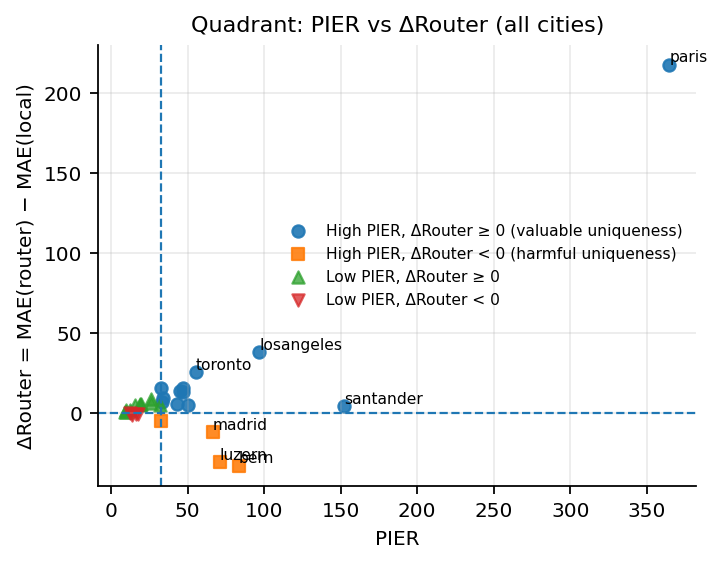

[Saved] ../results/figs/exp14_quadrant_pier_vs_delta_router_no_iqr.png


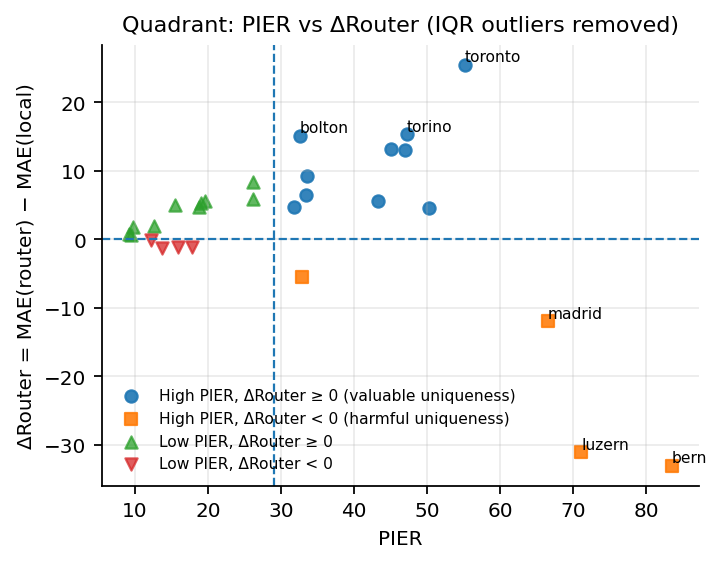

In [12]:
# -----------------------------
# Quadrant plot: PIER vs ΔRouter
# -----------------------------
def plot_quadrant_pier_delta_router(df_in: pd.DataFrame, title: str, pier_thr: float = None, save_name: str = None):
    """
    Quadrant view in (PIER, ΔRouter):
      - x-axis: PIER
      - y-axis: ΔRouter
    Thresholds:
      - vertical line: PIER median (or provided pier_thr)
      - horizontal line: ΔRouter = 0
    """
    d = df_in.copy()

    if pier_thr is None:
        pier_thr = float(d["PIER"].median())

    fig = plt.figure(figsize=(4.6, 3.6))
    ax = plt.gca()

    q1 = d[(d["PIER"] >= pier_thr) & (d["Delta_Router"] >= 0.0)]
    q2 = d[(d["PIER"] <  pier_thr) & (d["Delta_Router"] >= 0.0)]
    q3 = d[(d["PIER"] >= pier_thr) & (d["Delta_Router"] <  0.0)]
    q4 = d[(d["PIER"] <  pier_thr) & (d["Delta_Router"] <  0.0)]

    # Use different markers only (avoid custom colors)
    ax.scatter(q1["PIER"], q1["Delta_Router"], s=30, alpha=0.9, label="High PIER, ΔRouter ≥ 0 (valuable uniqueness)")
    ax.scatter(q3["PIER"], q3["Delta_Router"], s=30, alpha=0.9, marker="s", label="High PIER, ΔRouter < 0 (harmful uniqueness)")
    ax.scatter(q2["PIER"], q2["Delta_Router"], s=30, alpha=0.75, marker="^", label="Low PIER, ΔRouter ≥ 0")
    ax.scatter(q4["PIER"], q4["Delta_Router"], s=30, alpha=0.75, marker="v", label="Low PIER, ΔRouter < 0")

    ax.axvline(pier_thr, linewidth=1.0, linestyle="--")
    ax.axhline(0.0, linewidth=1.0, linestyle="--")

    ax.set_xlabel("PIER")
    ax.set_ylabel("ΔRouter = MAE(router) − MAE(local)")
    ax.set_title(title)

    # Annotate a few informative cities
    to_anno = []
    to_anno += d.sort_values("PIER", ascending=False)["City"].head(4).tolist()
    to_anno += d.sort_values("Delta_Router", ascending=False)["City"].head(3).tolist()
    to_anno += d.sort_values("Delta_Router", ascending=True)["City"].head(3).tolist()
    to_anno = list(dict.fromkeys(to_anno))

    for city in to_anno:
        sub = d[d["City"] == city]
        if sub.empty:
            continue
        x = float(sub.iloc[0]["PIER"])
        y = float(sub.iloc[0]["Delta_Router"])
        ax.text(x, y, city, fontsize=7, ha="left", va="bottom")

    ax.legend(loc="best", fontsize=7)
    plt.tight_layout()

    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)

    plt.show()


# All cities
plot_quadrant_pier_delta_router(
    df0,
    title="Quadrant: PIER vs ΔRouter (all cities)",
    pier_thr=float(df0["PIER"].median()),
    # pier_thr=float(df["PIER"].quantile(0.75)),
    save_name="exp14_quadrant_pier_vs_delta_router_all.png",
)

# IQR outliers removed (PIER-based)
plot_quadrant_pier_delta_router(
    df_no_iqr,
    title="Quadrant: PIER vs ΔRouter (IQR outliers removed)",
    pier_thr=float(df_no_iqr["PIER"].median()),
    # pier_thr=float(df["PIER"].quantile(0.75)),
    save_name="exp14_quadrant_pier_vs_delta_router_no_iqr.png",
)
